## **Libraries**

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import numpy as np
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

## **Import Dataset**

In [3]:
df=pd.read_csv("mbti_dataset.csv")

In [4]:
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


## **Preprocessing data**

In [22]:
df["target_EI"]=df["type"].apply(lambda row: row[0])
df["target_NS"]=df["type"].apply(lambda row: row[1])
df["target_TF"]=df["type"].apply(lambda row: row[2])
df["target_PJ"]=df["type"].apply(lambda row: row[3])

In [23]:
df.head()

,type,posts,target_EI,target_NS,target_TF,target_PJ
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,I,N,F,J
1,ENTP,'I'm finding the lack of me in these posts ver...,E,N,T,P
2,INTP,'Good one _____ https://www.youtube.com/wat...,I,N,T,P
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",I,N,T,J
4,ENTJ,'You're fired.|||That's another silly misconce...,E,N,T,J


In [57]:
y1=[]
y2=[]
barWidth = 0.4
r1 = range(len(y1))
r2 = [x + barWidth for x in r1]

In [58]:
y1.append(df["target_EI"].value_counts()[0])
y2.append(df["target_EI"].value_counts()[1])

In [59]:
y1.append(df["target_NS"].value_counts()[0])
y2.append(df["target_NS"].value_counts()[1])

In [60]:
y1.append(df["target_TF"].value_counts()[0])
y2.append(df["target_TF"].value_counts()[1])

In [61]:
y1.append(df["target_PJ"].value_counts()[0])
y2.append(df["target_PJ"].value_counts()[1])

([<matplotlib.patches.Wedge at 0x7fd8dd370c50>,
 [Text(-0.35352847293610057, 1.0416417900715529, 'P'),
  Text(0.3535285704616412, -1.041641756971824, 'J')])

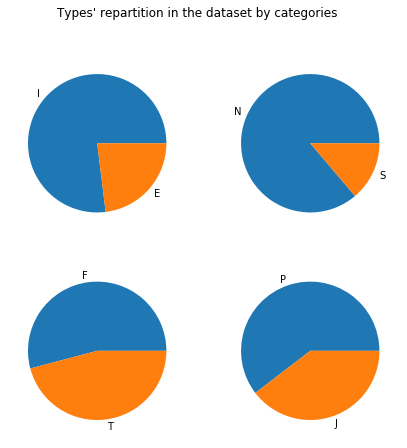

In [100]:
fig,ax = plt.subplots(2,2,figsize=(7,7))
fig.suptitle("Types' repartition in the dataset by categories")
ax[0, 0].pie([y1[0],y2[0]], labels = ['I', 'E'])
ax[0, 1].pie([y1[1],y2[1]], labels = ['N', 'S'])
ax[1, 0].pie([y1[2],y2[2]], labels = ['F', 'T'])
ax[1, 1].pie([y1[3],y2[3]], labels = ['P', 'J'])

Categories FT and PJ are quite balanced. Accurracy will be adequate.
However, types E and S are underrepresented in their respective categories, so f1_score will be better these categories.

### **Clean Data**

In [102]:
stop_words = stopwords.words("english")
#create an object of class PorterStemmer
porter = PorterStemmer()

In [103]:
def cleanData(posts):
    # Lowercase
    clean_text = posts.lower()
    #remove all hyperlinks
    clean_text = re.sub(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})','',clean_text)
    word_list = word_tokenize(clean_text)
    clean_posts = []
    for word in word_list:
        if word.isalpha() and word not in stop_words:
            word = porter.stem(word)
            clean_posts.append(word)
    return clean_posts


In [104]:
df["posts_preprocessed"]= df["posts"].apply(lambda row: cleanData(row))

## **Models**

### **Vectorization**

In [105]:
cv = CountVectorizer()
tfidf = TfidfVectorizer()

In [108]:
X=df["posts_preprocessed"].map(' '.join)

In [109]:
cnt_vector = cv.fit_transform(X)
tfidf_vector = tfidf.fit_transform(X)

In [152]:
vectors={'cnt_vector':cnt_vector,'tfidf_vector':tfidf_vector}

In [ ]:
X_train_EI,X_test_EI,y_train_EI,y_test_EI = train_test_split(cnt_vector,df["target_EI"],test_size=0.2)


### **Predictions**

We will test the following classifiers for each category:
 * RandomForestClassifier
 * MultinomialNB
 * LinearSVC

In [117]:
classifiers = [
    RandomForestClassifier(),
    MultinomialNB(),
    LinearSVC()
    ]

**EI category**:

In [159]:
for i in vectors:
    X_train,X_test,y_train,y_test = train_test_split(vectors[i],df["target_EI"],test_size=0.2)
    for classifier in classifiers:
        model = classifier.fit(X_train, y_train)
        predictions=model.predict(X_test)
        classification=metrics.classification_report(y_test,predictions,zero_division=0)
        print("%s + %s"%(i,classifier))
        print(classification)

cnt_vector + RandomForestClassifier()
              precision    recall  f1-score   support

           E       0.00      0.00      0.00       363
           I       0.79      1.00      0.88      1372

    accuracy                           0.79      1735
   macro avg       0.40      0.50      0.44      1735
weighted avg       0.63      0.79      0.70      1735

cnt_vector + MultinomialNB()
              precision    recall  f1-score   support

           E       0.61      0.40      0.48       363
           I       0.85      0.93      0.89      1372

    accuracy                           0.82      1735
   macro avg       0.73      0.67      0.69      1735
weighted avg       0.80      0.82      0.81      1735

cnt_vector + LinearSVC()
              precision    recall  f1-score   support

           E       0.52      0.60      0.56       363
           I       0.89      0.85      0.87      1372

    accuracy                           0.80      1735
   macro avg       0.70      0.73   

As said before, we have to look at f1-score for EI category. It seems that tfidf_vector() + LinearSVC() fit better the category

**NS category:**

In [160]:
for i in vectors:
    X_train,X_test,y_train,y_test = train_test_split(vectors[i],df["target_NS"],test_size=0.2)
    for classifier in classifiers:
        model = classifier.fit(X_train, y_train)
        predictions=model.predict(X_test)
        classification=metrics.classification_report(y_test,predictions,zero_division=0)
        print("%s + %s"%(i,classifier))
        print(classification)

cnt_vector + RandomForestClassifier()
              precision    recall  f1-score   support

           N       0.86      1.00      0.92      1487
           S       0.00      0.00      0.00       248

    accuracy                           0.86      1735
   macro avg       0.43      0.50      0.46      1735
weighted avg       0.73      0.86      0.79      1735

cnt_vector + MultinomialNB()
              precision    recall  f1-score   support

           N       0.87      0.97      0.92      1487
           S       0.42      0.14      0.21       248

    accuracy                           0.85      1735
   macro avg       0.65      0.55      0.56      1735
weighted avg       0.81      0.85      0.82      1735

cnt_vector + LinearSVC()
              precision    recall  f1-score   support

           N       0.91      0.93      0.92      1487
           S       0.54      0.48      0.50       248

    accuracy                           0.87      1735
   macro avg       0.73      0.70   

As said before, we have to look at f1-score for NS category. It seems that tfidf_vector()/CountVectorizer() + LinearSVC() fit better the category

**TF category:**

In [161]:
for i in vectors:
    X_train,X_test,y_train,y_test = train_test_split(vectors[i],df["target_TF"],test_size=0.2)
    for classifier in classifiers:
        model = classifier.fit(X_train, y_train)
        predictions=model.predict(X_test)
        classification=metrics.classification_report(y_test,predictions,zero_division=0)
        print("%s + %s"%(i,classifier))
        print(classification)
        


cnt_vector + RandomForestClassifier()
              precision    recall  f1-score   support

           F       0.71      0.91      0.79       920
           T       0.85      0.57      0.68       815

    accuracy                           0.75      1735
   macro avg       0.78      0.74      0.74      1735
weighted avg       0.77      0.75      0.74      1735

cnt_vector + MultinomialNB()
              precision    recall  f1-score   support

           F       0.80      0.86      0.83       920
           T       0.83      0.76      0.79       815

    accuracy                           0.81      1735
   macro avg       0.81      0.81      0.81      1735
weighted avg       0.81      0.81      0.81      1735

cnt_vector + LinearSVC()
              precision    recall  f1-score   support

           F       0.79      0.80      0.79       920
           T       0.77      0.76      0.77       815

    accuracy                           0.78      1735
   macro avg       0.78      0.78   

As said before, we have to look at precision for FT category. It seems that tfidf_vector() + LinearSVC() fit better the category

**PJ category:**

In [162]:
for i in vectors:
    X_train,X_test,y_train,y_test = train_test_split(vectors[i],df["target_PJ"],test_size=0.2)
    for classifier in classifiers:
        model = classifier.fit(X_train, y_train)
        predictions=model.predict(X_test)
        classification=metrics.classification_report(y_test,predictions,zero_division=0)
        print("%s + %s"%(i,classifier))
        print(classification)

cnt_vector + RandomForestClassifier()
              precision    recall  f1-score   support

           J       0.71      0.13      0.22       709
           P       0.62      0.96      0.75      1026

    accuracy                           0.62      1735
   macro avg       0.66      0.55      0.48      1735
weighted avg       0.65      0.62      0.53      1735

cnt_vector + MultinomialNB()
              precision    recall  f1-score   support

           J       0.70      0.57      0.63       709
           P       0.74      0.83      0.78      1026

    accuracy                           0.72      1735
   macro avg       0.72      0.70      0.70      1735
weighted avg       0.72      0.72      0.72      1735



/Users/pierremecchia/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


cnt_vector + LinearSVC()
              precision    recall  f1-score   support

           J       0.68      0.62      0.65       709
           P       0.75      0.80      0.78      1026

    accuracy                           0.73      1735
   macro avg       0.72      0.71      0.71      1735
weighted avg       0.72      0.73      0.72      1735

tfidf_vector + RandomForestClassifier()
              precision    recall  f1-score   support

           J       0.80      0.16      0.26       696
           P       0.63      0.97      0.77      1039

    accuracy                           0.65      1735
   macro avg       0.72      0.57      0.51      1735
weighted avg       0.70      0.65      0.56      1735

tfidf_vector + MultinomialNB()
              precision    recall  f1-score   support

           J       0.00      0.00      0.00       696
           P       0.60      1.00      0.75      1039

    accuracy                           0.60      1735
   macro avg       0.30      0.5

As said before, we have to look at precision for JP category. It seems that tfidf_vector() + LinearSVC() fit better the category

## **Conclusion**

tfidf_vector() + LinearSVC() is the model we will use to predict each category